In [3]:
import pandas as pd
import os
data_path = './dataset/'
df_price = pd.read_csv(os.path.join(data_path, 'samsung.csv'), encoding='utf8')
df_price.head(3)

,일자,시가,고가,저가,종가,거래량
0,20200107,55700,56400,55600,55800,9893846
1,20200106,54900,55600,54600,55500,10278951
2,20200103,56000,56600,54900,55500,15422255


- 시가 : 주식시장에서 처음 거래된 가격이다. 시가 형성 후 말꼬리가 길면 시가는 저항선으로, 말꼬리가 짧으면 시가는 지시선이 된다.

- 고가/저가 : 주식거래가 시작되면서 높은 가격으로 거래되었을때의 가격, 반대는 낮은 가격이다. 

- 종가 : 주식거래의 당일 맨 마지막 거래가 체결된 가격이다.


In [5]:
df_price.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


In [14]:
df_price.isnull().sum()

일자     0
시가     0
고가     0
저가     0
종가     0
거래량    0
연도     0
월      0
일      0
dtype: int64

=> 일자,시가, 고가, 저가, 거래량을 기준으로 '종가'를 예측

In [6]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

In [7]:
df_price

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30
...,...,...,...,...,...,...,...,...,...
9283,1985-01-09,126,126,122,123,324836,1985,1,9
9284,1985-01-08,129,129,127,127,845098,1985,1,8
9285,1985-01-07,129,130,128,129,771895,1985,1,7
9286,1985-01-05,129,129,128,128,108496,1985,1,5


Text(0, 0.5, 'price')

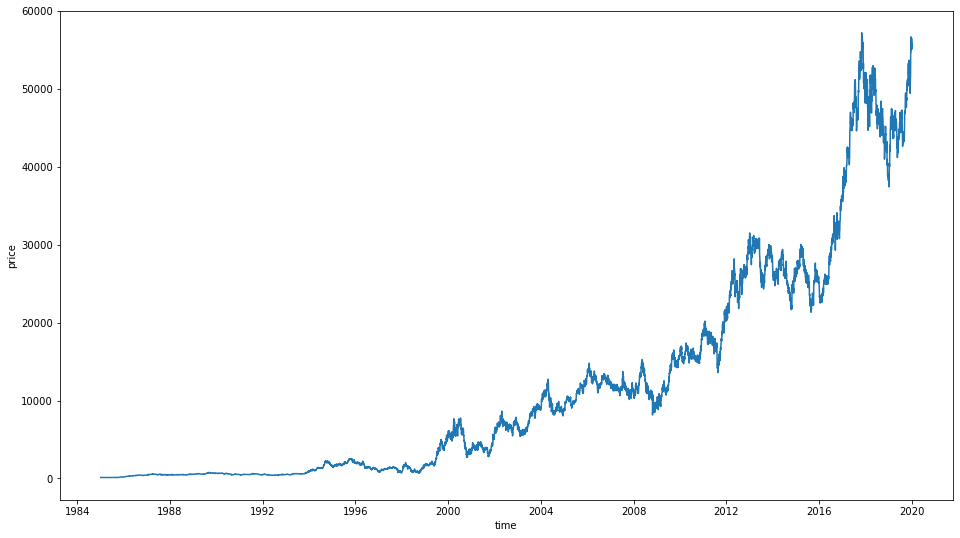

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 9))
sns.lineplot(y=df_price['종가'], x=df_price['일자']) # 삼전 올 ㅋ
plt.xlabel('time')
plt.ylabel('price')

In [15]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df_price[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled.head(3)

,시가,고가,저가,종가,거래량
0,0.968632,0.980489,0.979522,0.975133,0.030291
1,0.954691,0.966553,0.961868,0.969880,0.031470
2,0.973860,0.983973,0.967164,0.969880,0.047217


window_size : 얼마동안(기간)의 주가 데이터에 기반하여 다음날 종가를 예측할 것인가를 결정하는 parameter

과거 20일을 기반으로 내일 데이터를 예측한다고 가정하면 window_size=20이다.

In [17]:
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [19]:
print(train.shape)
print(test.shape)

(9088, 5)
(200, 5)


In [20]:
# 20일 기간의 데이터 셋을 묶어 주는 역할
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [23]:
import numpy as np
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((6086, 20, 4), (1522, 20, 4))


test_feature = test[feature_cols]
test_label = test[label_cols]

# test dataset (실제 예측 해볼 데이터) <- 200개 자른 데이터
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape
# ((180, 20, 4), (180, 1))

((180, 20, 4), (180, 1))

In [27]:
train_feature.shape

(9068, 20, 4)

In [28]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [30]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path='./'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
454/454 [==============================] - 12s 17ms/step - loss: 0.0357 - val_loss: 9.1416e-05

Epoch 00001: val_loss improved from inf to 0.00009, saving model to .\tmp_checkpoint.h5
Epoch 2/200
454/454 [==============================] - 6s 13ms/step - loss: 1.1605e-04 - val_loss: 1.1396e-04

Epoch 00002: val_loss did not improve from 0.00009
Epoch 3/200
454/454 [==============================] - 6s 14ms/step - loss: 1.0621e-04 - val_loss: 8.5236e-05

Epoch 00003: val_loss improved from 0.00009 to 0.00009, saving model to .\tmp_checkpoint.h5
Epoch 4/200
454/454 [==============================] - 6s 13ms/step - loss: 8.5544e-05 - val_loss: 7.1019e-05

Epoch 00004: val_loss improved from 0.00009 to 0.00007, saving model to .\tmp_checkpoint.h5
Epoch 5/200
454/454 [==============================] - 6s 14ms/step - loss: 9.0006e-05 - val_loss: 7.6765e-05

Epoch 00005: val_loss did not improve from 0.00007
Epoch 6/200
454/454 [==============================] - 7s 15ms/step - loss

454/454 [==============================] - 6s 14ms/step - loss: 1.6100e-05 - val_loss: 1.4328e-05

Epoch 00045: val_loss did not improve from 0.00001
Epoch 46/200
454/454 [==============================] - 7s 14ms/step - loss: 1.5109e-05 - val_loss: 7.0002e-05

Epoch 00046: val_loss did not improve from 0.00001
Epoch 47/200
454/454 [==============================] - 7s 15ms/step - loss: 2.0623e-05 - val_loss: 1.4341e-05

Epoch 00047: val_loss did not improve from 0.00001


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'NanumGothic'

In [32]:
!pip install finance-datareader

In [35]:
import FinanceDataReader as fdr

In [36]:
# 삼성전자(005930) 전체 (1996-11-05 ~ 현재)
samsung = fdr.DataReader('005930')

In [38]:
samsung

,Open,High,Low,Close,Volume,Change
Date,,,,,,
1997-07-01,1259,1286,1259,1269,167900,NaN
1997-07-02,1277,1313,1277,1296,169940,0.021277
1997-07-03,1295,1304,1283,1290,108460,-0.004630
1997-07-04,1295,1304,1286,1296,101780,0.004651
1997-07-05,1286,1301,1286,1287,56160,-0.006944
...,...,...,...,...,...,...
2021-07-01,80500,80600,80000,80100,13382882,-0.007435
2021-07-02,80000,80400,79900,80000,8753097,-0.001248
2021-07-05,80100,80800,80000,80400,8330969,0.005000


In [39]:
samsung.index

DatetimeIndex(['1997-07-01', '1997-07-02', '1997-07-03', '1997-07-04',
               '1997-07-05', '1997-07-07', '1997-07-08', '1997-07-09',
               '1997-07-10', '1997-07-11',
               ...
               '2021-06-24', '2021-06-25', '2021-06-28', '2021-06-29',
               '2021-06-30', '2021-07-01', '2021-07-02', '2021-07-05',
               '2021-07-06', '2021-07-07'],
              dtype='datetime64[ns]', name='Date', length=6000, freq=None)

In [40]:
samsung['Year'] = samsung.index.year
samsung['Month'] = samsung.index.month
samsung['Day'] = samsung.index.day

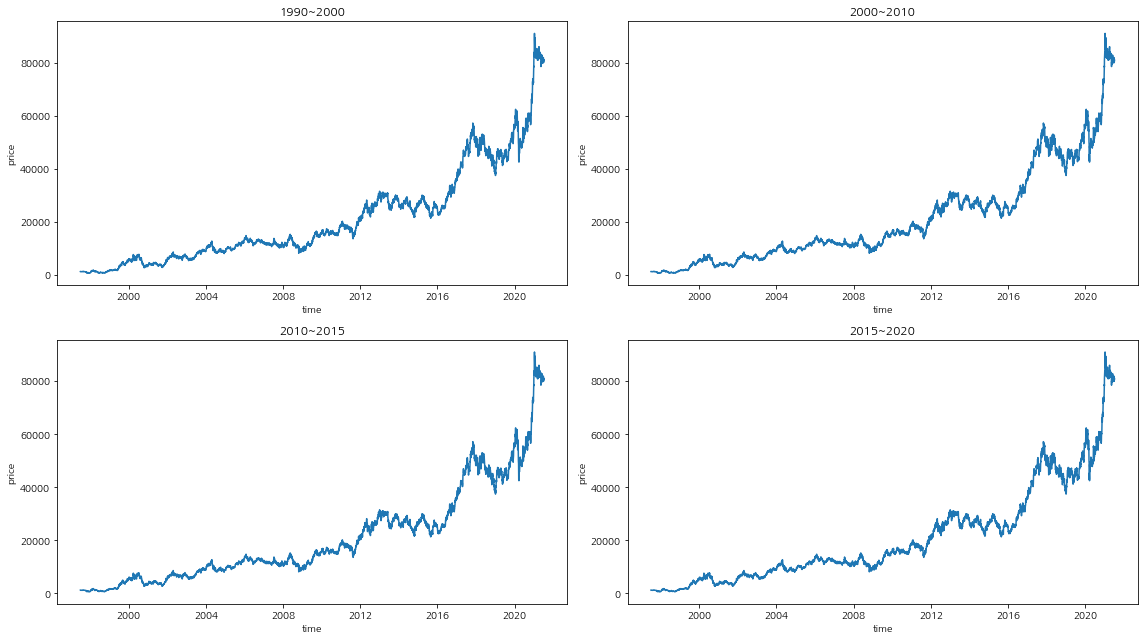

In [41]:
time_steps = [['1990', '2000'], 
              ['2000', '2010'], 
              ['2010', '2015'], 
              ['2015', '2020']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)
for i in range(4):
    ax = axes[i//2, i%2]
    df = samsung.loc[(samsung.index > time_steps[i][0]) & (samsung.index < time_steps[i][1])]
    sns.lineplot(y=samsung['Close'], x=samsung.index, ax=ax)
    ax.set_title(f'{time_steps[i][0]}~{time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
plt.tight_layout()
plt.show()

MSE, MAE를 절충한 Huber loss 함수도 있다.